# Lab #1: Prefix Scan and Barriers
#### Time Taken for lab: ~25hours

In [222]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [223]:
OP_FIL_DIR = "output"

In [224]:
def load_data(file_name):
    with open(f'{OP_FIL_DIR}/{file_name}.pkl', 'rb') as f:
        loaded_data = pickle.load(f)
    return loaded_data

def normalize_time(row, base_times):
    file = row['file']
    return base_times[file]/row['time'] if file in base_times else row['time']

def load_df(file_name):
    data = load_data(file_name)
    df = pd.DataFrame(data)
    df['time'] = pd.to_numeric(df['time'], errors='coerce')
    base_times = df[df['thread'] == 0].set_index('file')['time'].to_dict()
    df['speed_up'] = df.apply(lambda row: normalize_time(row, base_times), axis=1)
    df['time'] = df['time']/ 1000
    return df

def plot_graph(df):
    fig, axs = plt.subplots(1, 2, figsize=(18, 6), sharey=False)
    for file_name, group in df.groupby('file'):
        axs[0].plot(group['thread'], group['time'], marker='o', label=file_name)
        
        axs[1].plot(group['thread'], group['speed_up'], marker='o', label=file_name)

    axs[0].set_xlabel('Thread')
    axs[0].set_ylabel('Time')
    axs[0].set_title('Thread vs Time (ms) for Different Files')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].set_xlabel('Thread')
    axs[1].set_ylabel('Speed Up')
    axs[1].set_title('Thread vs speed up over sequential')
    axs[1].legend()
    axs[1].grid(True)
        
    plt.tight_layout()
    plt.show()

In [225]:
q1_df = load_df("q1")
q1_df.head()

,file,loop,thread,time,speed_up
0,1k.txt,100000,0,44.137,1.000000
1,1k.txt,100000,2,41.836,1.055000
2,1k.txt,100000,4,30.916,1.427643
3,1k.txt,100000,6,21.787,2.025841
4,1k.txt,100000,8,15.546,2.839123


## Step 1: Parallel Implementation
### Brent-Kung Parallel Inclusive Prefix SUM Algorithm
After extensive research on work efficient prefix sum algorithms, I have found references of Brent Kung's parallel prefix sum algorithm which is kind of similar to Blelloch's algorithm but is inclusive in nature.
 
Brent Kung's parallel prefix sum algorithm divides the computation into main phases:
1. Up-Sweep (reduce) phase: This phase calculates the partial sums by traversing up a binary tree structure, accumulating results. It's analogous to a tree reduction where values are combined in pairs up the tree until the root.
2. Down-Sweep phase: This phase computes the final prefix sums by traversing down the tree using the accumulated results from the up-sweep phase to calculate the prefix sums for all elements.

I had two major concerns that I had to address while implementing this algorithm:
1. Handling input of varying lengths: This issue is addressed by this algorithm by design, I wanted to avoid additional padding to the array to make it closer to power of 2s. I have implemented the algorithm in such a way that if the array length is even, the summation of the last element is handled in the up-sweep phase and if the array is of odd length, the prefix sum of the last element is handled in the down-sweep phase. 
2. Reusing threads when no. of threads < log(n): I run another loop inside the striding outer loop to handle this case. For example, if there are 8 elements in the array with 2 threads, when stride=1, each thread is utilized 2 times in the up-sweep phase.

Synchronization is achieved using a p_thread barrier.

Time Complexity: O(log(n)) - This algorithm executes 2*log(n) parallel iterations - log(n) in up-sweep phase and log(n) in downsweep phase. <BR>
Work Efficiency: O(n) - The iterations do n/2, n/4,..1, (2-1), …., (n/4-1), (n/2-1) useful adds. Total adds: (n-1) + (n-2) – (log(n) -1) = 2*(n-1) – log(n) -> O(n) work

Pseudocode:

```C++
int stride = 1;
int idx;
//Up-Sweep Phase
for (; stride < n_vals; stride *=2 ) {
    idx = -1;
    for (int i = 0; idx< n_vals; i+=n_threads) { //reusing threads
        idx = (thread_id + 1 + i) * stride * 2 - 1; //Notice that index calculation is same in up-sweep and down-sweep
        if ((idx < n_vals) && (idx-stride) >=0 ) { //Boundary check
            output[idx] = op(output[idx], output[idx-stride], n_loops); //Notice that how the index is used is different in up-sweep and down-sweep
        } 
    }
    barrier_wait(args); //sync the threads
}

//Down-Sweep Phase
for (; stride > 0; stride /= 2) {
    idx = -1;
    for (int i = 0; idx < n_vals; i+=n_threads) {
        idx = (i + thread_id + 1) * stride * 2 - 1;
        if ((idx < n_vals) && (idx+stride < n_vals)) { //Boundary check
            output[idx+stride] = op(output[idx+stride], output[idx], n_loops);
        }
    }
    barrier_wait(args); //sync the threads
}

```

Below is a dry-run of the algorithm with threads count as 4, for an array of size 16. The number in red represents the thread_id and s stands for stride value.

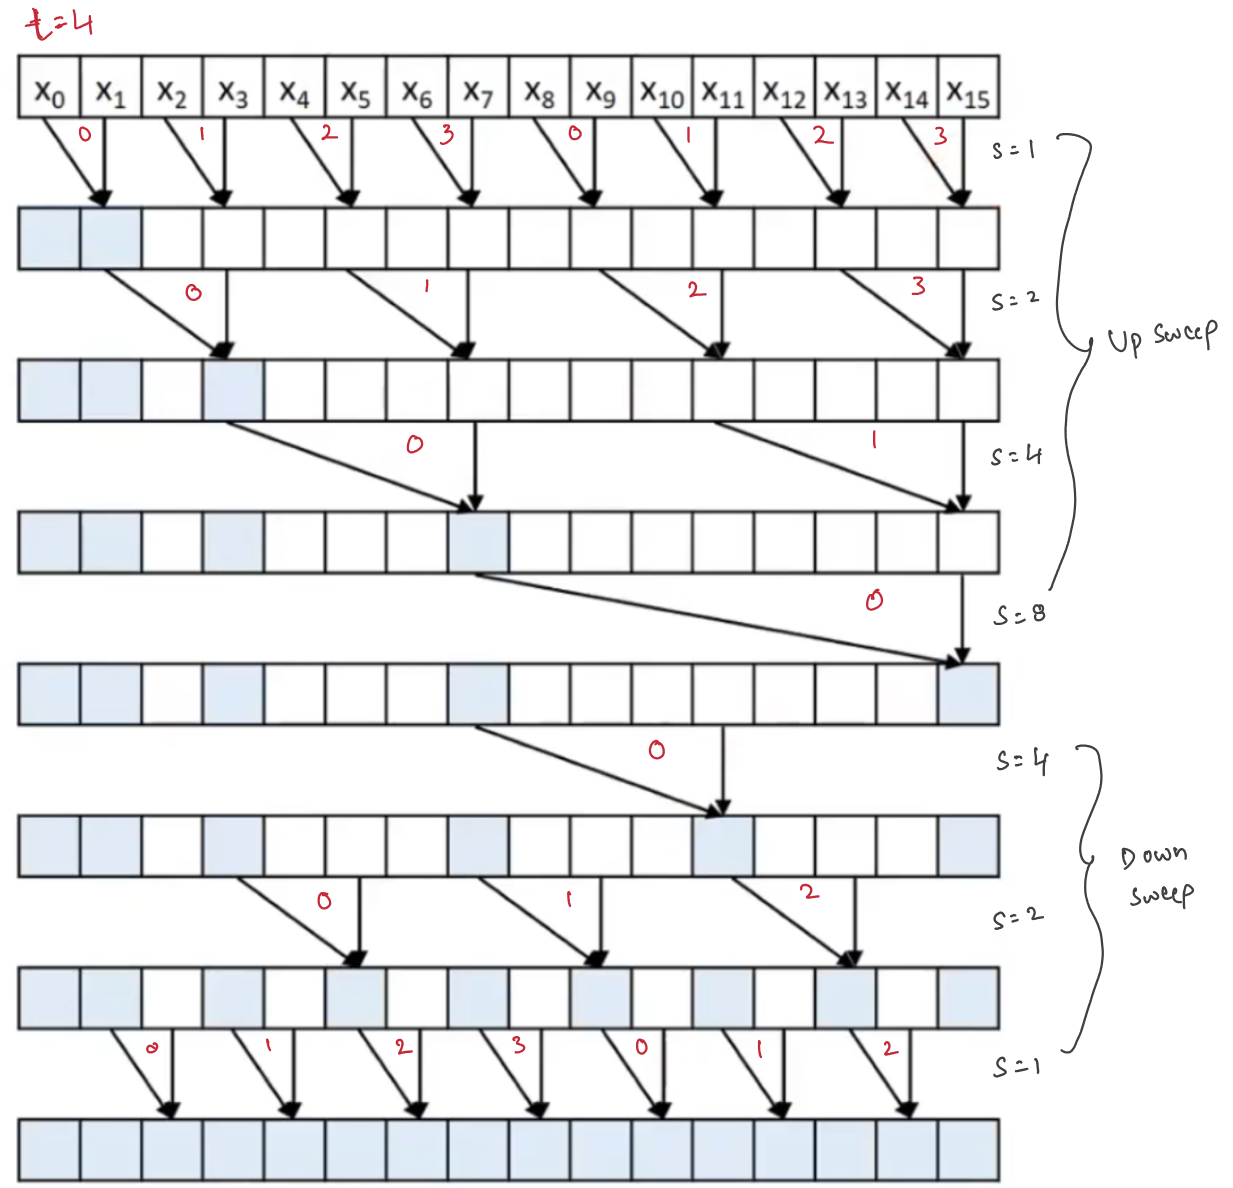

## Performance Results
Below are the two graphs with l=100000. <BR>
1. Graph-1: Shows the Threads Vs Time in ms
2. Graph-2: Captures the same meaning but in the % of speed up.

#### Observations:
1. The execution time when thread count=2, slightly increased for files with 8k and 16k compared to sequential version. I believe this is because of long delays introduced due to barrier synchronization that is caused due to heavy workload in individual threads. So thread 1 is done with it's work while thread 2 might not and thread 1 is wasting time waiting. The multi-cores are not efficiently being used for thread count = 2.
2. As the number of threads increases from 2, the execution times decreases significantly before reaching a plateau. This shows a significant boost in performance almost 3x in all the cases.
3. But as thread count increase beyond a certain point, looks to 14 in all the cases, there is little to no benefit in adding more threads.
4. Another observation is that, the efficiency is directly related to the amount of work that needs to be done. For the 1k file, there is no added benefit in doing parallel processing.

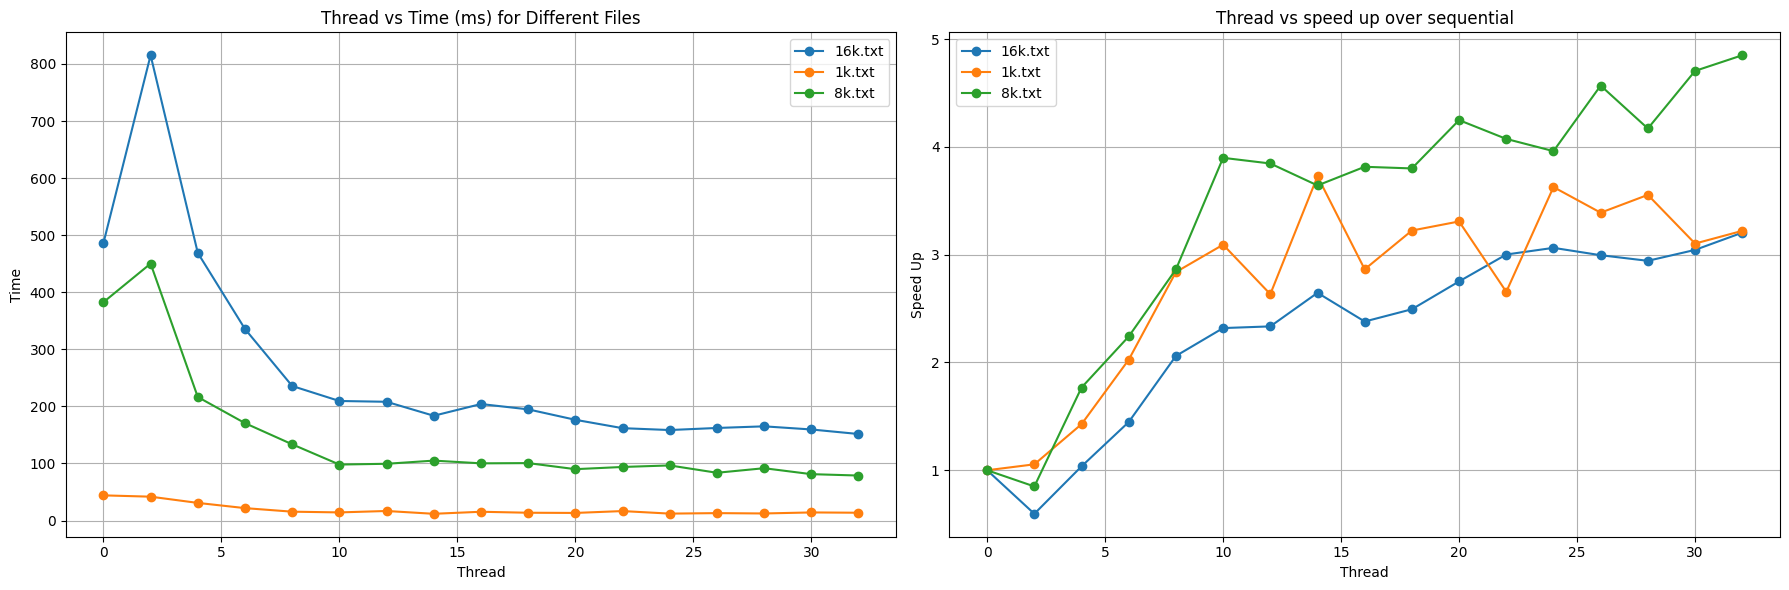

In [226]:
plot_graph(q1_df)

## Step 2: Playing with Operators
Below are the two graphs with l=10. <BR>
1. Graph-1: Shows the Threads Vs Time in ms
2. Graph-2: Captures the same meaning but in the % of speed up.

#### Observations:
1. When l was set to 10 => each individual operation is fast, with increase in number of threads there is a degrade in performance. This is due to frequent context switching and blocking which outweighs the benefits of parallel processing.

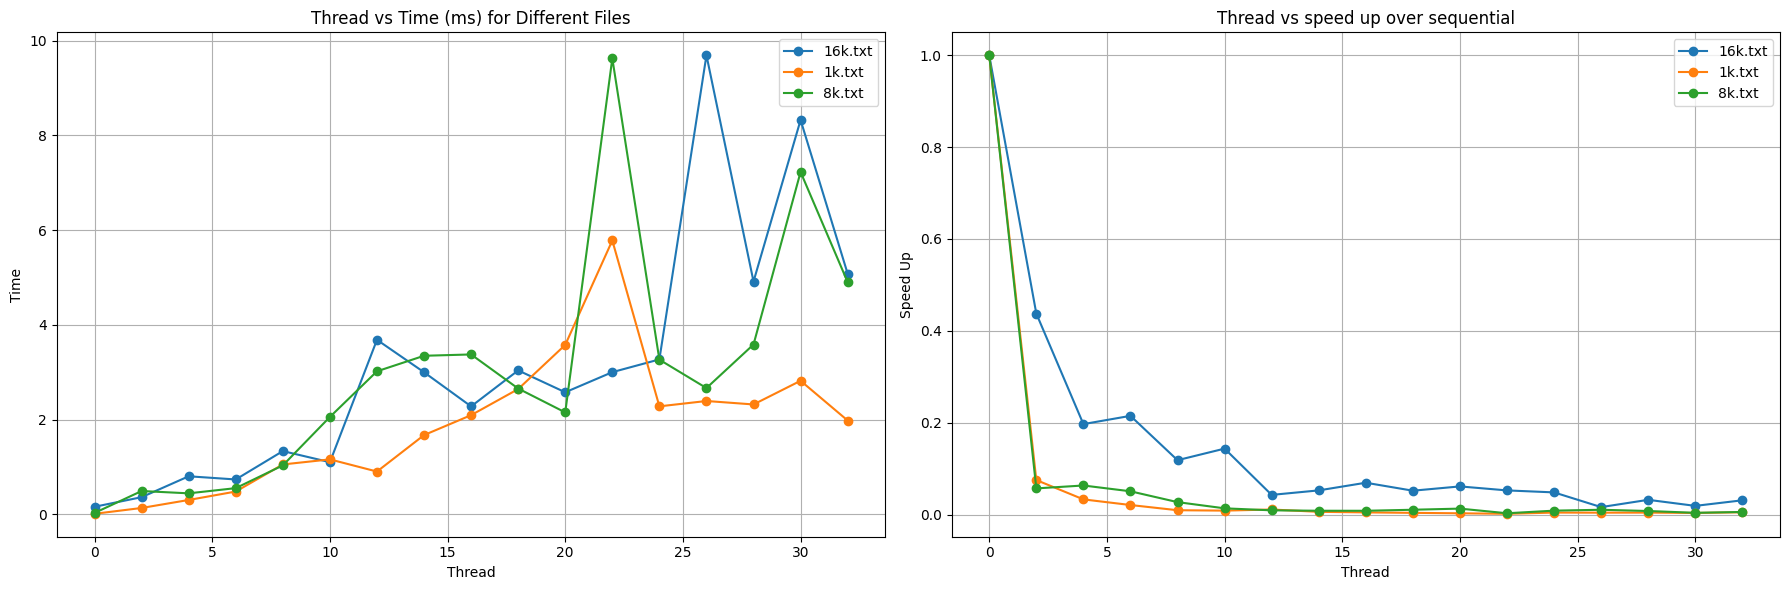

In [227]:
q2_df = load_df("q2")
plot_graph(q2_df)

In [228]:
def find_inflexion_point(group):
    sequential_time = group.loc[group['thread'] == 0, 'time'].values[0]
    
    parallel_group = group[group['thread'] != 0].copy()
    parallel_group['time_diff'] = abs(parallel_group['time'] - sequential_time)
    
    inflection_idx = parallel_group['time_diff'].idxmin()
    inflection_thread = parallel_group.loc[inflection_idx, 'thread']
    inflection_time = parallel_group.loc[inflection_idx, 'time']
    time_diff = parallel_group.loc[inflection_idx, 'time_diff']
    
    return pd.Series({
        'sequential_time': sequential_time,
        'parallel_time_at_inflection': inflection_time,
        'thread': inflection_thread,
        'time_diff': time_diff
    })

def find_min_diff_loop_for_file(group):
    inflection_point_idx = group['time_diff'].idxmin()
    return group.loc[inflection_point_idx]

def get_inflexion_points(inx_df):
    inflexion_points = inx_df.groupby(['file', 'loop'])[inx_df.columns].apply(find_inflexion_point).reset_index()
    return inflexion_points.groupby('file')[inflexion_points.columns].apply(find_min_diff_loop_for_file).reset_index(drop=True)

def plot_inflexion(sequential_df, parallel_df):
    files = sequential_df['file'].unique()
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

    for i, file in enumerate(files):
        data1 = sequential_df[sequential_df['file'] == file]
        data2 = parallel_df[parallel_df['file'] == file]

        axs[i].plot(data1['loop'], data1['time'], marker='o', label='sequential', color='green')
        
        axs[i].plot(data2['loop_x'], data2['time'], marker='o', label='parallel', color='red')

        # axs[i].plot(data2['loop_y'], data2['time'], color='blue', label="Inflexion Point")
        
        axs[i].set_xlabel('Loops')
        axs[i].set_ylabel('Time')
        axs[i].set_title(f'Inflexion point for {file} found with threads={data2["thread"].unique()}')
        axs[i].legend()
        axs[i].grid(True)
        
    plt.tight_layout()
    plt.show()

## Inflexion Point
Below are 3 graphs for each of the files with threads where inflection point was lowest. The Blue line indicates the inflexion point. There could be more than 1 but the lowest is plotted on the graph.

#### Observations:
1. Varying l is nothing but varying the duration of operation within each individual thread - lower value indicates a faster task, higher value indicates a slower task. 
2. When l is low => a faster task per thread, sequential version is faster than parallel version as it does not run into thread waits and context switching. At this point, parallel implementation does not offer any benefit.
3. For 1k file, sequential version is almost always faster than parallel version. 

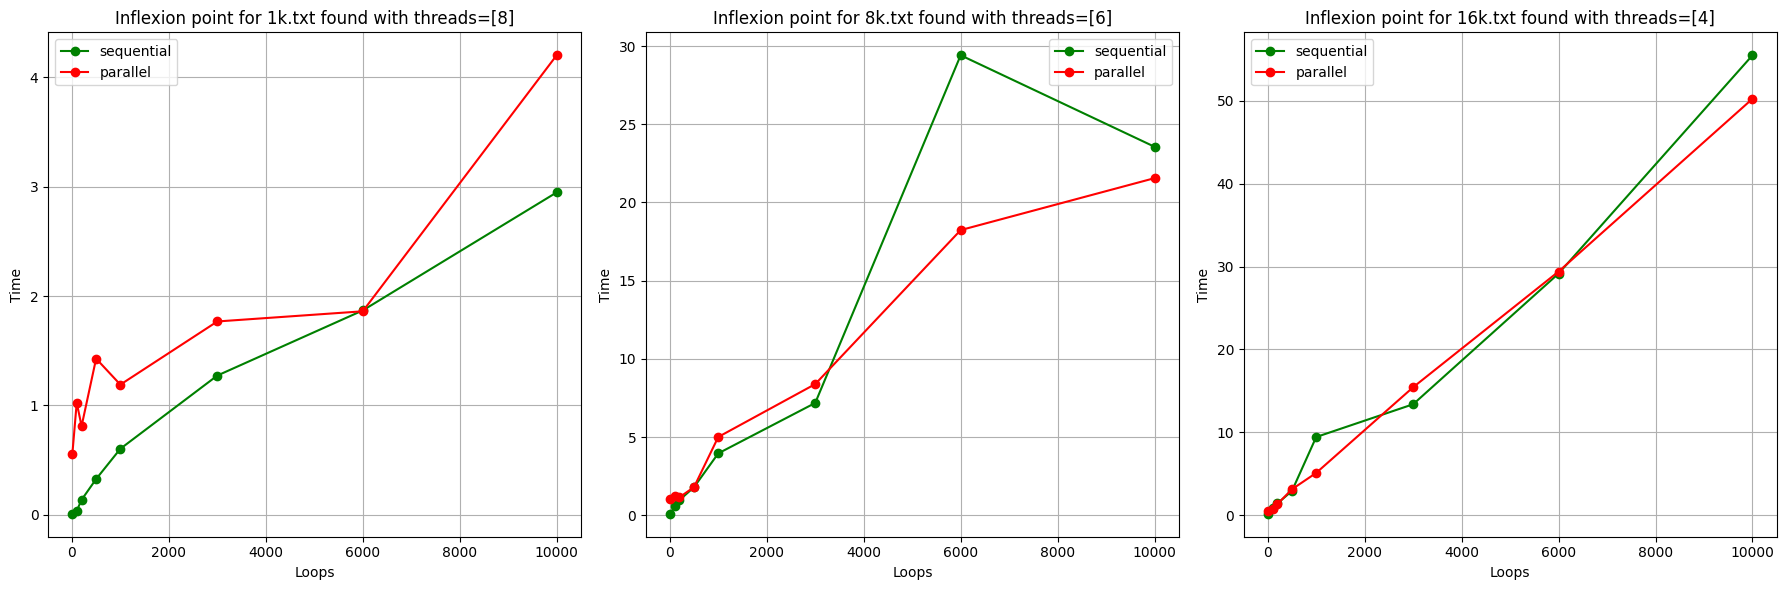

In [229]:
inx_df = load_df("inx")
inx_df.head()
min_diff_per_file = get_inflexion_points(inx_df)
min_diff_per_file
sequential_df = inx_df[inx_df['thread'] == 0]
parallel_df = inx_df.merge(min_diff_per_file, on=['thread', 'file'])
plot_inflexion(sequential_df, parallel_df)

# Step 3: Barrier Implementation
I have followed the recommendation in the assignment and implemented the barrier using pthread's spinlock. I have referred to the pseudocode that was discussed in the lecture using semaphores and counter for barrier implementation.

#### Pseudocode
```C++
n_threads = n_threads;
counter = 0;
spin_lock(departure);

spin_lock(arrival);   
if (++counter < n_threads) {  
    spin_unlock(arrival);
} else {
    spin_unlock(departure);
}

spin_lock(departure);

if (--counter > 0) {  
    spin_unlock(departure);
} else {
    spin_unlock(arrival);
}
```

##### how is/isn't your implementation different from pthread barriers? 
1. Spin lock barrier uses spinlocks -> thread is blocked until the process is complete. 
2. PThread barrier uses mutexes and condition variables and avoids blocking of thread.
3. PThread barrier has better performance over spin locks as CPU utilization is less and threads are efficiently used.

##### In what scenario(s) would each implementation perform better than the other? 
1. Spin lock barrier would perform better if the time spent in the critical section is very minimal - short high frequency tasks.
2. PThread barriers would perform better if threads involved have higher execution time in the critical section or where each thread's execution time is not uniform - long non uniform tasks.

##### What are the pathological cases for each? 
1. Spin lock barrier can cause CPU starvation leading to performance degradation if threads have to wait for longer periods.
2. PThread barriers are not ideal for real-time systems where the task duration is of very short duration. The frequent context switching between threads is going to cause performance degradation.


#### Observations:
1. With l=100000
    * The performance appears to first increase and then as number of threads increase, the performance degrades.
2. With l=10
    * The performance remains fairly constant in comparison with the sequential but degrades as we increase the number of threads.
    * As we have previously established, spin locks work best for short lived tasks. 

But in both the cases, as the number of threads increase, the performance degrade. This is most likely due to spin locks that's keeping the CPU busy from doing useful work.

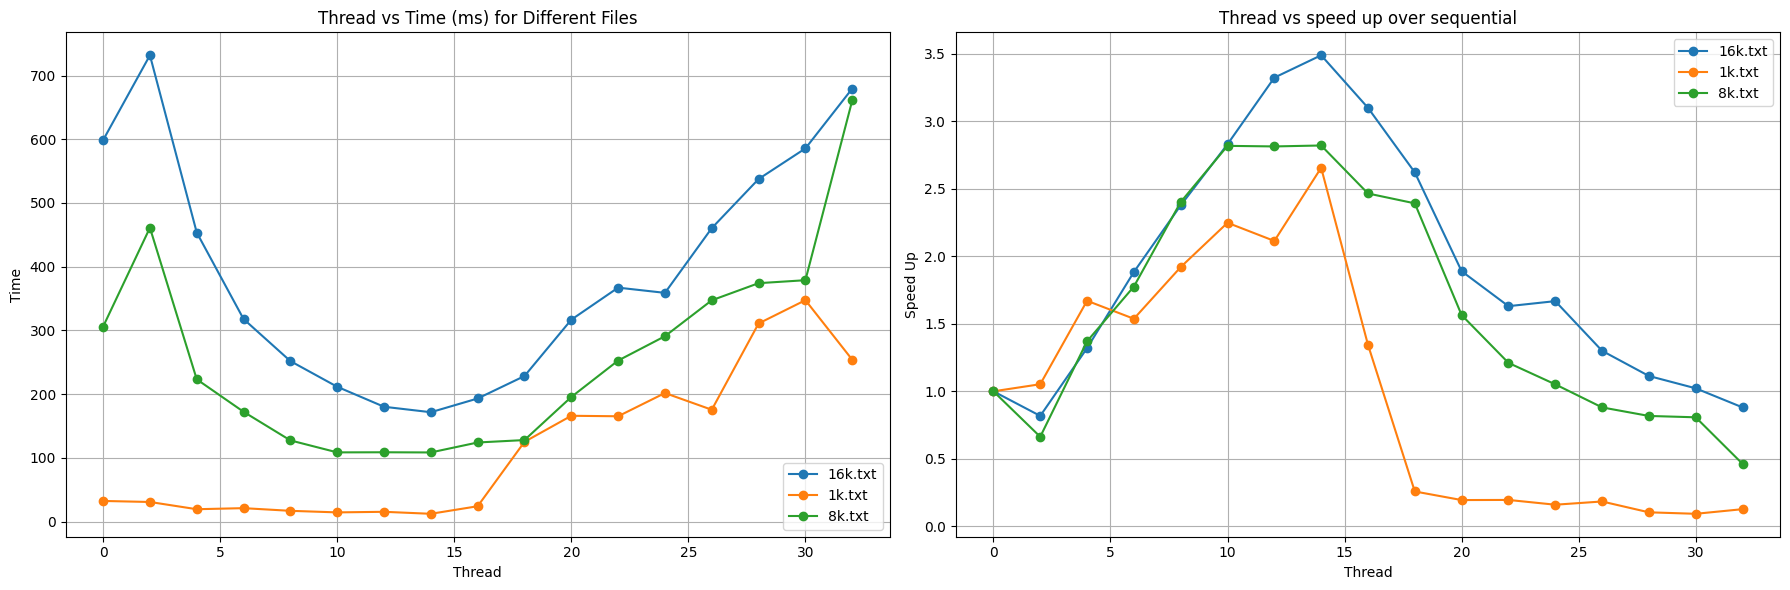

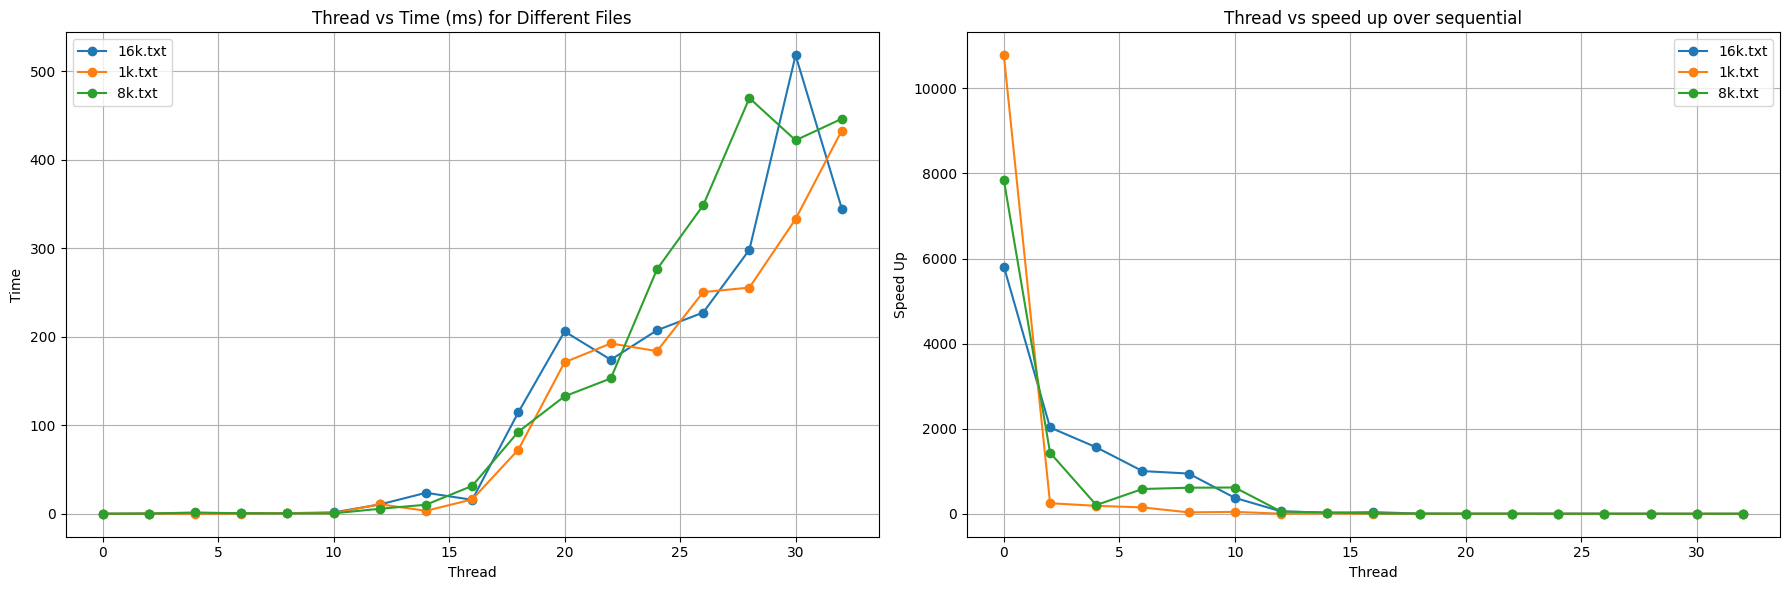

In [230]:
q3_df = load_df("q3")
plot_graph(q3_df[q3_df['loop'] == 100000])
plot_graph(q3_df[q3_df['loop'] == 10])

#### Inflexion points:
The results here are inline with what we have established before for most part except that for a 1k file, spin barrier's parallel version outperforms pthread's barrier parallel version. 

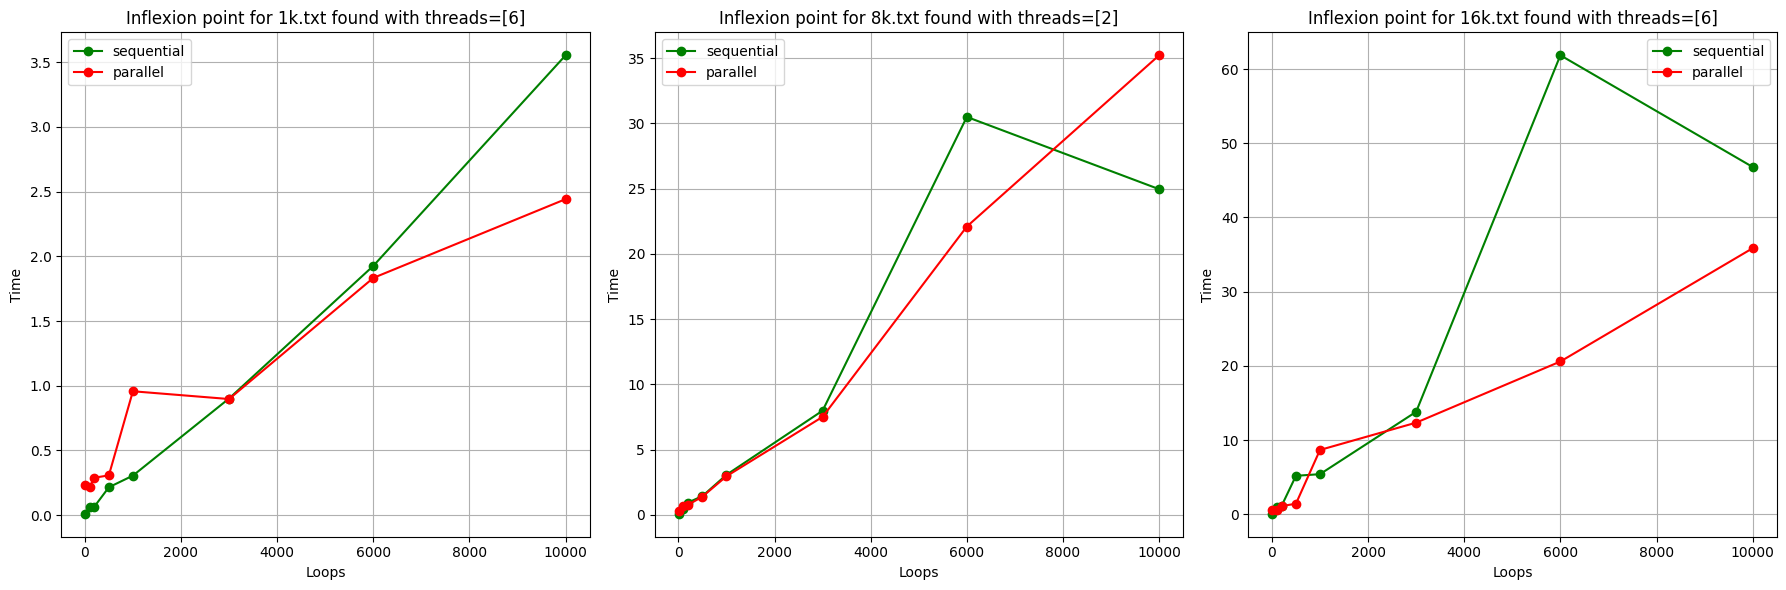

In [231]:
inx_df_spin = load_df("inx_spin")
inx_df_spin.head()
inflexion_points_spin = get_inflexion_points(inx_df_spin)
sequential_df_spin = inx_df_spin[inx_df_spin['thread'] == 0]
parallel_df_spin = inx_df_spin.merge(inflexion_points_spin, on=['thread', 'file'])
plot_inflexion(sequential_df_spin, parallel_df_spin)

1. I was not expecting to see a significant decrease in performance with spin barrier as compared to pthread's implementation with increase in number of threads.
2. I was expecting spin barrier to perform better than pthread barrier for 1k file, which is inline with my expectation.

## Workload scenario
#### Spin Barrier:
1. High Contention with many threads: This scenario will lead to CPU starvation.
2. CPU Intensive workload: Spinlocks themselves consume a lot of CPU time, so if the task itself requires CPU, it will slow down the entire process.

#### Pthread Barrier
1. Faster tasks with many barriers: The frequent context switching between threads will lead to degrade in the performance.
2. Low Latency workloads: Sleeping of threads will lead to unpredictability in the system's performance.